<a href="https://colab.research.google.com/github/huskeypm/cellmigration/blob/main/expt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exptl analysis
Last ran on colab, 240311

This notebook
* loads tif files from a migration experiment,
* uses trackpy to find moving cells, and
* fits a linear equation to their mean square displacements to obtain a diffusion coefficient.

Data
* My input data is currently located at
/content/drive/MyDrive/public/
which is mounted to google drive.
* This path will need to be adjusted if data are stored elsewhere

Usage:
* Copy files of interest to an appropriate google drive directory
(current set is from Emily's Feb collections)
* run the first part of the code to completion and **modify the default parameters** to work with your data
* once the right parameters are determined, process your remaining files; a csv file should result for each input file

To analyze
* Use second part of notebook to load in csv files and plot

Install needed packages



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install pims trackpy

Check out cellmigration github repo

In [1]:
!git clone https://github.com/huskeypm/cellmigration.git
#!cd cellmigration; git pull

Cloning into 'cellmigration'...
remote: Enumerating objects: 885, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 885 (delta 147), reused 130 (delta 111), pack-reused 684
Receiving objects: 100% (885/885), 15.05 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (554/554), done.


In [2]:
import sys
sys.path.append("cellmigration")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
import tifffile

import expt_analysis.trackcells as tc

# Process raw images
## Image processing

Define inputs (pretty much the only places needed for making changes)

In [4]:
!ls /content/cellmigration

ls: cannot access '/content/cellmigration': No such file or directory


In [32]:
# read in image and show first frame
user = "Emily"
#user = "PKH"
useGdrive = False
if user == "Emily":
  name='3'
  path="/home/ekrueger2/microscopy_data/022824"
  fileName=path+"/Position_{}_movie.tif".format(name)
    #fileName=r"C:\Users\ekrue\Downloads\12_13_23_{}.tif".format(name)
elif user == "PKH":
  name = "Position_1" #
  #name = "Position_3"
  gpath=('/content/drive')
  path=gpath+"/MyDrive/public/"
  fileName = path+"/%s_movie.tif"%name
  useGdrive=True
  sourcePath = "/content/cellmigration/"
#
#  Parameters to edit
#
# time/frame conversion
fr = 180 # s/fr # experiment

# image processing parameters (disable downsample and crop for full analyses )
downsampleRate = 10
crop=[[300,900],[300,900]]
thresh=105


# determine parameters to track particles
# paramters: diameter, minmass
#- positiion 1
#iameter=101 # adjust me first
#inmass = 75000
#- positiion 2
#diameter=91  # adjust me first
#minmass = 100
#- positiion 3
#diameter=101  # adjust me first
#minmass = 1000
#cropped position 1 values
diameter=21
minmass=15000

# for fitting MSDs
fittingRange=[0,100]



Read images

Mount google drive.
I added a shortcut to a shared tif file in my 'public' directory

 /content/drive/MyDrive/public/

In [33]:
if useGdrive:
  from google.colab import drive
  drive.mount(gpath)

(480, 1200, 1200)


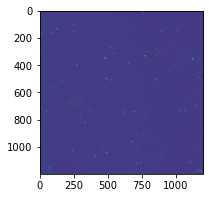

In [34]:
# read image
raw_data = tifffile.imread(fileName)
print(raw_data.shape)

multiChannel = False
if multiChannel:
  channel=0
  frames=raw_data[:,channel,:,:]
else:
  frames=raw_data[:,:,:]

plt.imshow(frames[0,:,:])


(48, 600, 600)
0


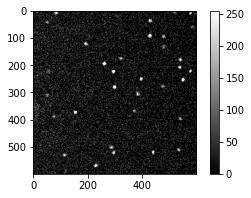

In [35]:

thresh=105
threshed = tc.ProcessFrames(frames,downsampleRate=downsampleRate,crop=crop,thresh=thresh)



print(np.min(threshed[0,:]))


### Tracking

* If cells aren't detecting, reduce diameter/minmass or both.
* The displayed mass histogram can help with this optimization

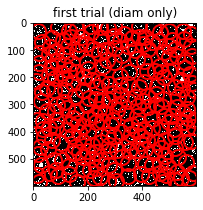

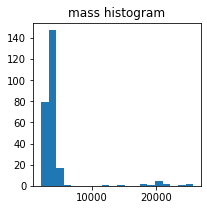

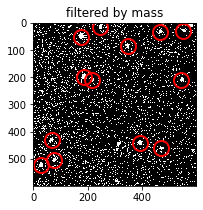

In [36]:

dummy = tc.TrialParams(threshed,refFrame=0,diameter=diameter,minmass=minmass)
if dummy.shape[0] <1:
  print("Error finding cells; try different parameters")
else:
  finalStack = threshed


In [37]:
# run batch/tracking
fb=tc.DoTracking(finalStack,diameter=diameter,minmass=minmass)

try:
  print("shape final %d"%fb.shape[0])
except:
  print("Unsuccessful tracking")

fb

Frame 47: 7 features
shape final 492


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,16.569206,245.859653,20041.011393,5.366194,0.210051,144.398908,50490.0,NaN,0
1,28.816687,551.740979,19416.218642,4.969615,0.177707,158.125888,42585.0,NaN,0
2,34.419754,466.075300,20880.931000,5.098325,0.047225,148.218451,47685.0,NaN,0
3,51.336495,176.463305,25810.550456,6.662079,0.029071,122.031474,72420.0,NaN,0
4,86.227289,347.267149,20583.320080,5.306333,0.166260,143.944706,50745.0,NaN,0
...,...,...,...,...,...,...,...,...,...
487,224.539659,294.087432,16866.421928,4.221902,0.074306,176.997785,33405.0,NaN,47
488,254.674065,548.680018,17168.187877,4.317742,0.100921,175.007018,33915.0,NaN,47
489,281.191989,297.948234,16948.979627,4.257856,0.005600,169.967891,35700.0,NaN,47
490,373.359671,154.591445,16399.506363,4.195772,0.052828,179.256060,32640.0,NaN,47


### MSD analyses

<font color=red>WARNING: the msd plot needs to be rescaled according to correct spatial and temporal units</font>

Frame 47: 7 trajectories present.
Found 492 
Retained 428 particles
Drift 
                y           x
frame                       
1       4.833933   -6.535281
2      -1.424505    1.628669
3       4.811824   -1.785722
4       8.846608  -20.459652
5      15.321120  -23.107586
6      13.622275  -28.264746
7      10.540936  -33.981138
8       4.571576  -39.153731
9       2.423108  -41.121430
10      2.744591  -49.582074
11     -0.326685  -59.046127
12      4.426562  -64.679379
13      9.143289  -68.402661
14     13.079206  -68.164801
15      3.993035  -62.232727
16      6.149101  -77.438702
17      3.303766  -82.456826
18      0.236513  -74.465946
19     -1.132478  -80.964566
20     -8.124523  -95.161821
21    -11.094319  -97.310550
22     -6.929960  -97.548727
23     -9.518378 -110.209274
24    -20.436745 -112.174095
25    -21.518878 -104.520802
26    -21.938274  -99.538207
27    -25.712884 -106.581322
28    -19.517758 -109.723319
29    -12.598108 -102.879033
30     -1.965822  -92.428

/home/ekrueger2/anaconda3/lib/python3.9/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/ekrueger2/anaconda3/lib/python3.9/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


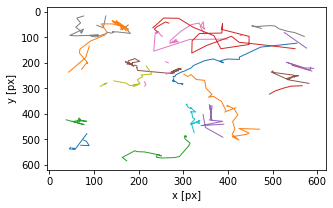

Double check, data contains ALL particle trajectories? (%d)
slope/intercept [    5.196047   -2679.40884751]


<Figure size 360x216 with 0 Axes>

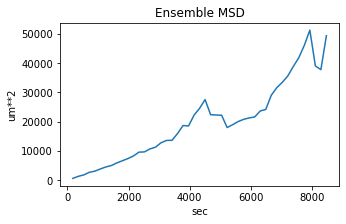

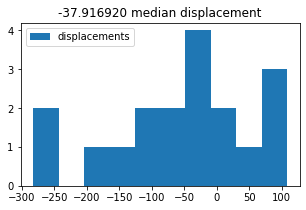

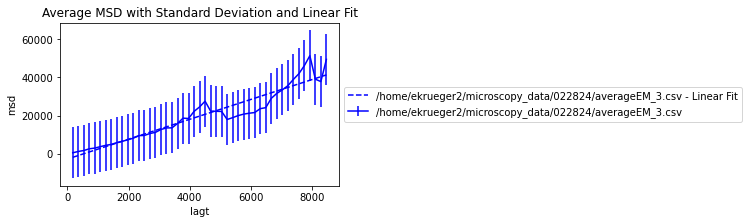

In [38]:

# compute MSD
ts,traj,msd,im,em=tc.DoMSD(
    fb,
    maxDist=100, # maximum displacement between frames in pixel
    maxMissFrame=10, # allowed number of frames a particle can disappear
    minFrame=10, # minimum number of frames a trajectory needs to last
    pixelSize=1.1, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva 10X: 0.65) and (Spinning Disk: 1.1 at 10X)
    frameRate=1/fr, # image acquisition rate in frames/sec
    max_lagtime=160, # intervals of frames out to which MSD is computed
    name=name
)


# get displacements
dists, xdists = tc.CalcDistances(traj) # performed on trajectories BEFORE drift-correction
med = np.median(xdists)
plt.figure()
plt.title("%f median displacement"%med)
plt.hist(xdists,label="displacements")
plt.legend(loc=0)

# save average MSD for each run to csv file
msdFileName=path+'/averageEM_{}.csv'.format(name)
diffFileName=path+'/diff_{}.csv'.format(name)
if name is not None:
    em.to_csv(msdFileName)
    np.savetxt(diffFileName,np.array(xdists))
    # prompt: save pandas dataframe
    traj.to_csv(path+'/traj_{}.csv'.format(name))
    fb.to_csv(path+'/fbframe_{}.csv'.format(name))

msdFile={
    path+'/averageEM_{}.csv'.format(name):{"color":"blue"}
}
plt.figure()
tc.doMSDFit(msdFile, fittingRange=fittingRange)

#individual MSDs? save figures?

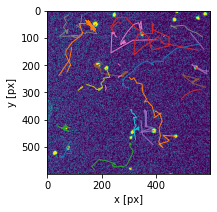

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [39]:
plt.figure()
plt.imshow(threshed[0,:,:])
tp.plot_traj(traj)

# Post processing

Create list of names

In [40]:
path

'/home/ekrueger2/microscopy_data/022824'

slope/intercept [    5.196047   -2679.40884751]


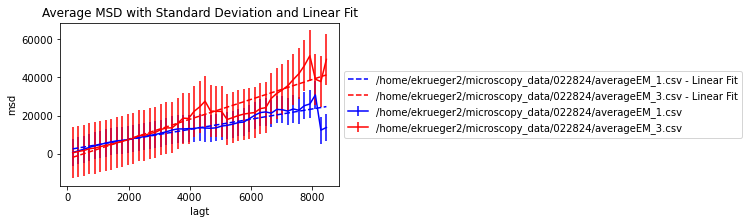

In [42]:
# import average MSD csv files and plot with Std and linear fit

average_MSD_files={
    'averageEM_Position1.csv':{"color": "blue"},
    'averageEM_Position2.csv':{"color": "purple"},
    'averageEM_Position3.csv':{"color": "red"},
    'averageEM_Position4.csv':{"color": "orange"},
    'averageEM_Position5.csv':{"color": "yellow"},
    'averageEM_Position6.csv':{"color": "green"}
    }
average_MSD_files={
    path+'/averageEM_1.csv':{"color": "blue"},
    path+'/averageEM_3.csv':{"color": "red"},
}


fittingRange=[0,100]
tc.doMSDFit(average_MSD_files, fittingRange=fittingRange)



<font color=red>NEED TO EDIT ONCE I HAVE THE low/high ATP JOBS </font>


### No ATP

Not sure how this naming scheme was decided upon

In [39]:
# former path
filenames_confinement = []
filenames_confinement.append(
    path+'/averageEM_Position_1.csv'
    )
diff_filenames = []
diff_filenames.append(
    path+'/diff_Position_1.csv'
    )
caseNames = ["-ATP" for x in range(len(filenames_confinement))]


### With ATP

In [40]:
# with atp?
filenames_confinement_ATP = []
filenames_confinement_ATP.append(
    path+'/averageEM_Position_2.csv'
    )
diff_filenames_ATP = []
diff_filenames_ATP.append(
    path+'/diff_Position_2.csv'
    )

caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

In [41]:
filenames_confinement =  filenames_confinement + filenames_confinement_ATP
diff_filenames =  diff_filenames + diff_filenames_ATP
caseNames = caseNames + caseNamesATP

In [42]:
print(filenames_confinement)

['/content/drive/MyDrive/public//averageEM_Position_1.csv', '/content/drive/MyDrive/public//averageEM_Position_2.csv']


### Load data
We used to load/process images here, but now we just use postprocessed data here (tracking happens elsewhere in notebook)

In [43]:
cases = dict()
class empty:pass

In [52]:
for i,filename in enumerate(filenames_confinement):

    # store data
    case = empty()

    #
    case.name = filenames_confinement[i]
    ar = pd.read_csv(filenames_confinement[i])
    print("Lag time isn't quite what we want")
    case.time1 = ar['lagt']
    case.dataavg1 = ar['msd']
    print("D is needed")
    ar = pd.read_csv(filename)
#    case.D = D
    ar = pd.read_csv(diff_filenames[i])
    case.dists = ar

    cases[caseNames[i]] = case


Lag time isn't quite what we want
D is needed
Lag time isn't quite what we want
D is needed


Text(0, 0.5, 'Prob')

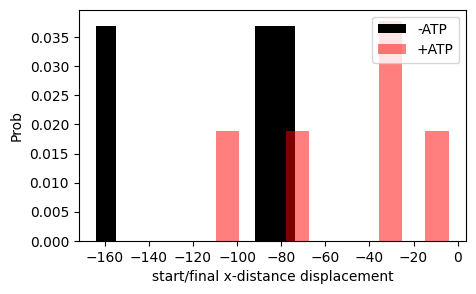

In [56]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,color='black',label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,color='red',label='+ATP')
plt.legend(loc=0)
plt.xlabel("start/final x-distance displacement")
plt.ylabel("Prob")


* Tests
```
cd tests
```
* Run (kafka)
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [62]:
sourcePath = "/content/cellmigration/"
simFile = sourcePath+"expt_analysis/expt.csv"
simData = np.loadtxt(simFile)

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb.py		     tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


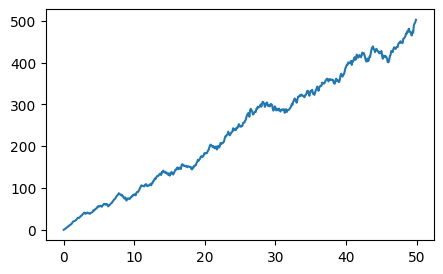

In [63]:
plt.plot(simData[:,0],simData[:,1])

<font color=red>Need to also load sim case where we measure displacements </font>

Not storing D right now until timescale is worked out


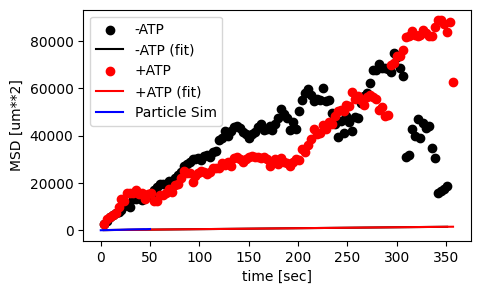

In [68]:
print("Not storing D right now until timescale is worked out")
sec_to_min = 60.
caseName = '-ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='k',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,'k',label=caseName+" (fit)")

caseName = '+ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='r',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,color='r',label=caseName+" (fit)")

# sims
plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [min]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [ ]:
msd[9]

206.09947014256585